# Simple workflow with twarc

Exploring a simple workflow for docnow:  what does it look like to fetch a sample set of tweets, perform basic analysis, and end up with a summary suitable for non-technical users?

## Setup

We'll start by setting up our environment.  I'm still getting used to writing notebooks intended for audiences broader than either "me" or "my class" so I'll try some new conventions.  I like having python files that follow import grouping and sorting, so let's do that here.

### global imports

In [1]:
from collections import Counter
import json
import os
import sys
import time
from urllib.parse import urlparse

### common imports

In [2]:
%matplotlib inline

from IPython.display import display, Image
import matplotlib as mpl
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import seaborn as sns

### enable ipython autoreloading, as we'll tweak twarc

In [3]:
%load_ext autoreload
%autoreload 1

`%autoreload` is indeed magic.  Read more about it in the [IPython docs](http://ipython.readthedocs.org/en/stable/config/extensions/autoreload.html).  Here it means that anytime a `twarc` function (which we'll import with `%aimport` next) is called, the kernel should reload `twarc` first.  This allows me to change the library in the background and see the changes immediately here.

### local imports

In [4]:
%aimport twarc
import tweepy

We start with establishing an API connection using [twarc](https://github.com/edsu/twarc).  This requires establishing our API key credentials, which I've included in my shell environment, so let's assign them first.

In [5]:
consumer_key = os.environ.get('CONSUMER_KEY')
consumer_secret = os.environ.get('CONSUMER_SECRET')
access_token = os.environ.get('ACCESS_TOKEN')
access_token_secret = os.environ.get('ACCESS_TOKEN_SECRET')
t = twarc.Twarc(consumer_key=consumer_key, consumer_secret=consumer_secret,
                access_token=access_token, access_token_secret=access_token_secret)

## Fetching tweets using `search()`

Using our ```Twarc``` instance, we can now collect some data.  We'll save a little time by defining a function.

In [6]:
def get_tweets (count=5):
    i = 0
    tweets = []
    for tweet in t.search('lahoreblast', lang='en'):
        i += 1
        if i > count:
            break
        tweets.append(tweet)
    return tweets

In [7]:
tweets = get_tweets(5)
for tweet in tweets:
    print('%s - %s' % (tweet['id'], tweet["text"]))

716353520450973696 - RT @shekharkapur: no,
Jannat is not for u
for ur soul 
will forever be trapped
in death cries 
and screams
of little children
that you mass…
716352379503771648 - @LodhiMaleeha 2/2 and have our PM speak out against #IndianSpy agencies criminal activities within Pakistan. #LahoreBlast #APSKids #Baluch
716352158392836097 - RT @SamiulH83091414: @Khadimhussain4 #LahoreBlast killing 70 is a huge loss &amp; must be condemned, bt no one called them "martyred, courageou…
716351996924665857 - RT @MediaCellPPP: Chairman #PPP @BBhuttoZardari visited Jinnah Hospital #Lahore to inquire about the health of #LahoreBlast victims https:/…
716351878393675776 - RT @AhmadiyyaAUS: (PRESS RELEASE): Our thoughts and prayers are with innocent victims of #LahoreBlast - Terrorism has no religion. https://…


Just to be thorough, let's try that again:

In [45]:
tweets = get_tweets(5)
for tweet in tweets:
    print('%s - %s' % (tweet['id'], tweet["text"]))

714488383423307776 - If ur Religion requires u tO hate someone.....
U must need a New Religion
#LahoreBlast  #nohumanity
714488381720367104 - RT @RT_Erdogan: I strongly condemn the terrorist attack that took place in Lahore yesterday. Turkey stands by Pakistan as it always has bee…
714488373755437056 - RT @zara_hafeez: Please RT: 

#Lahore #LahoreBlast #LahoreAttack #Punjab #Pakistan #Karachi #Islamabad #Peshawar #GulshanIqbalPark https://…
714488367866580992 - Will big monuments light in the colors of #Pakistan's flag tonight? Aren't the victims humans after all?
#LahoreBlast
714488353794580480 - RT @NicoleGLeier: Sending thoughts of love, hope, and peace to the people of Pakistan and all those affected by #LahoreBlast. Our hearts go…


Do you notice how one of the tweets (#714488353794580480, the "@NicoleGLeier" RT) repeats?  This is due to the default behavior of the [search API call](https://dev.twitter.com/rest/reference/get/search/tweets) ```result_type``` option.  By default, it uses `mixed`, which includes a few popular tweets and then recent tweets.

If we change the twarc library (which I've now done under the hood) to accept the `result_type` option, we can explore this more directly.  And let's just look at the IDs to keep it simple.

In [8]:
def get_tweets (count=5, result_type='mixed'):
    i = 0
    tweets = []
    for tweet in t.search('lahoreblast', lang='en', result_type=result_type):
        i += 1
        if i > count:
            break
        tweets.append(tweet)
    return tweets

In [9]:
tweets = get_tweets(5, result_type='popular')
for tweet in tweets:
    print('%s - %s' % (tweet['id'], tweet["text"]))

714134717814202368 - The world seems to be infested with heartless sick people..heartbreaking news.My prayers to the families of the victims #LahoreBlast
714333047273889792 - I don't care what your fighting for but u do this to children u are going to burn in hell. #LahoreBlast
714127906843271168 - Malala's statement on the tragic #LahoreBlast today. https://t.co/2xrSoGK6Yq
714150230942298112 - Canada condemns the deplorable bombing in Lahore, Pakistan. Our thoughts and prayers are with all those killed or injured. #LahoreBlast
714120753143218177 - It's a park for gods sake!! Children on swings!! How can anybody even have the heart to do this. #LahoreBlast


And repeating the same thing to see if the same popular tweets come through:

In [48]:
tweets = get_tweets(5, result_type='popular')
for tweet in tweets:
    print('%s - %s' % (tweet['id'], tweet["text"]))

714134717814202368 - The world seems to be infested with heartless sick people..heartbreaking news.My prayers to the families of the victims #LahoreBlast
714127906843271168 - Malala's statement on the tragic #LahoreBlast today. https://t.co/2xrSoGK6Yq
714150230942298112 - Canada condemns the deplorable bombing in Lahore, Pakistan. Our thoughts and prayers are with all those killed or injured. #LahoreBlast
714333047273889792 - I don't care what your fighting for but u do this to children u are going to burn in hell. #LahoreBlast
714120753143218177 - It's a park for gods sake!! Children on swings!! How can anybody even have the heart to do this. #LahoreBlast


Exactly the same!  Let's try a little more substantial set.

In [10]:
popular1 = set([t['id'] for t in get_tweets(20, result_type='popular')])
popular2 = set([t['id'] for t in get_tweets(20, result_type='popular')])
print('intersection: %s' % len(popular1.intersection(popular2)))
print('difference: %s' % len(popular1.difference(popular2)))

intersection: 15
difference: 0


Okay then, let's try again with `recent`.  We need to "sleep" a little in between request to ensure there's a little time lag between calls, otherwise we'll just get mostly the same tweets again the second time.  Thirty seconds later, the most recent tweets should be new for a big trending tag.

In [11]:
recent1 = set([t['id'] for t in get_tweets(20, result_type='recent')])
# a little delay to allow some new tweets through
time.sleep(30)
recent2 = set([t['id'] for t in get_tweets(20, result_type='recent')])
print('intersection: %s' % len(recent1.intersection(recent2)))
print('difference: %s' % len(recent1.difference(recent2)))

intersection: 19
difference: 1


Works!  [Pull request](https://github.com/edsu/twarc/pull/91) sent. :)

## Counting things:  tags, URLs, mentions, media

Now that we have that settled, let's grab a larger set of tweets and start counting things.

In [12]:
tweets = get_tweets(5, result_type='recent')
for tweet in tweets:
    print('%s - %s' % (tweet['id'], tweet["text"]))

716353877927456768 - RT @MediaCellPPP: Chairman #PPP @BBhuttoZardari visited Jinnah Hospital #Lahore to inquire about the health of #LahoreBlast victims https:/…
716353520450973696 - RT @shekharkapur: no,
Jannat is not for u
for ur soul 
will forever be trapped
in death cries 
and screams
of little children
that you mass…
716352379503771648 - @LodhiMaleeha 2/2 and have our PM speak out against #IndianSpy agencies criminal activities within Pakistan. #LahoreBlast #APSKids #Baluch
716352158392836097 - RT @SamiulH83091414: @Khadimhussain4 #LahoreBlast killing 70 is a huge loss &amp; must be condemned, bt no one called them "martyred, courageou…
716351996924665857 - RT @MediaCellPPP: Chairman #PPP @BBhuttoZardari visited Jinnah Hospital #Lahore to inquire about the health of #LahoreBlast victims https:/…


In [13]:
recent_tweets = get_tweets(5000, result_type='recent')

In [14]:
len(recent_tweets)

5000

In [15]:
counter_hashtags = Counter()
for tweet in recent_tweets:
    counter_hashtags.update([hashtag['text'] for hashtag in tweet['entities']['hashtags']
                             if not hashtag['text'].lower() == 'lahoreblast'])

In [16]:
counter_hashtags.most_common(10)

[('Pakistan', 525),
 ('LahoreAttack', 247),
 ('PrayForPakistan', 229),
 ('Lahore', 189),
 ('PPP', 166),
 ('IslamabadSiege', 105),
 ('PrayForLahore', 104),
 ('AcompromisedPM', 94),
 ('PCB', 91),
 ('dtmag', 88)]

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]),
 <a list of 50 Text xticklabel objects>)

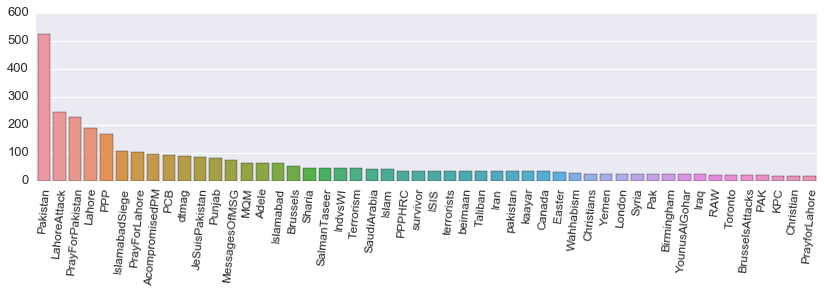

In [17]:
x, y = zip(*counter_hashtags.most_common(50))
f, ax = plt.subplots(figsize=(14, 3))
sns.barplot(x=x, y=y)
plt.yticks(fontsize=13)
plt.xticks(rotation=85, fontsize=12)

In [19]:
counter_urls = Counter()
for tweet in recent_tweets:
    counter_urls.update([url['expanded_url'] for url in tweet['entities']['urls']])

In [20]:
counter_urls.most_common(25)

[('http://www.independent.co.uk/news/world/asia/islamist-protesters-call-for-sharia-in-pakistan-after-salman-taseer-blasphemy-row-a6956896.html',
  46),
 ('http://www.thehindu.com/news/international/article8414449.ece', 34),
 ('http://megatray6.blogspot.co.uk/2016/03/terrorism-and-sectarian-violence.html?m=1',
  32),
 ('http://www.theawaitedone.com/activities/2016/03/28/statement-the-lahore-blast',
  31),
 ('http://theawaitedone.com/activities/201', 28),
 ('http://www.dawn.com/news/1249300', 28),
 ('http://www.huffingtonpost.com/kashif-n-chaudhry/islam-requires-muslims-to-protect-christians_b_6961230.html',
  25),
 ('https://owaisnaqvi.wordpress.com/2016/03/28/too-little-too-late/', 24),
 ('http://ow.ly/107jo8', 23),
 ('http://www.younusalgohar.org/articles/understand-wahhabism-to-understand-why-world-younus-algohar/',
  22),
 ('http://www.huffingtonpost.in/farheen-rizvi/lahore-blast-exposes-the-_b_9569688.html',
  20),
 ('http://www.hipinpakistan.com/news/1149389/adele-pays-tribute-to

In [22]:
counter_domains = Counter()
for tweet in recent_tweets:
    counter_domains.update([urlparse(url['expanded_url']).netloc for url in tweet['entities']['urls']])

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]),
 <a list of 50 Text xticklabel objects>)

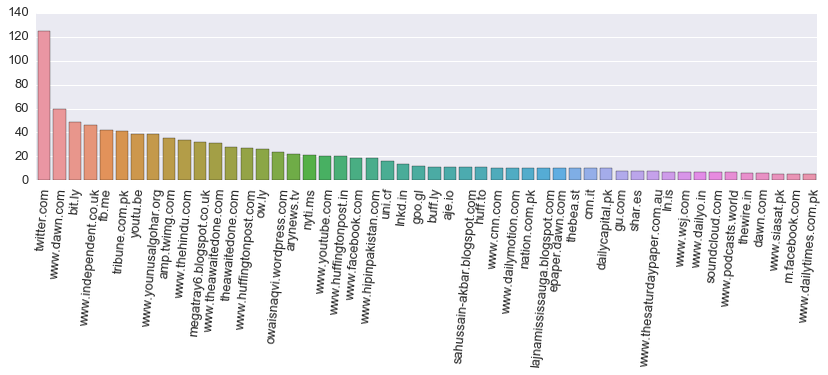

In [23]:
x, y = zip(*counter_domains.most_common(50))
f, ax = plt.subplots(figsize=(14, 3))
sns.barplot(x=x, y=y)
plt.yticks(fontsize=13)
plt.xticks(rotation=85, fontsize=13)

In [24]:
counter_mentions = Counter()
for tweet in recent_tweets:
    counter_mentions.update([m['screen_name'] for m in tweet['entities']['user_mentions']])

In [25]:
counter_mentions.most_common(25)

[('RT_Erdogan', 236),
 ('BBhuttoZardari', 176),
 ('iHrithik', 132),
 ('KamalFaridi', 90),
 ('sheenaabidashah', 89),
 ('realDonaldTrump', 89),
 ('newtgingrich', 88),
 ('ShahNafisa', 87),
 ('JustinTrudeau', 87),
 ('maiolsanauja', 84),
 ('gqforbes', 81),
 ('MediaCellPPP', 79),
 ('mehdifoundation', 78),
 ('Gurmeetramrahim', 73),
 ('NatashaFatah', 68),
 ('younusalgohar', 67),
 ('Adele', 64),
 ('itsRaniMukerji', 59),
 ('faisalmirppp', 58),
 ('WasayJalil', 56),
 ('sharmeenochinoy', 51),
 ('priyankachopra', 48),
 ('dawn_com', 47),
 ('mazdaki', 46),
 ('muftimenk', 43)]

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71, 72, 73, 74]), <a list of 75 Text xticklabel objects>)

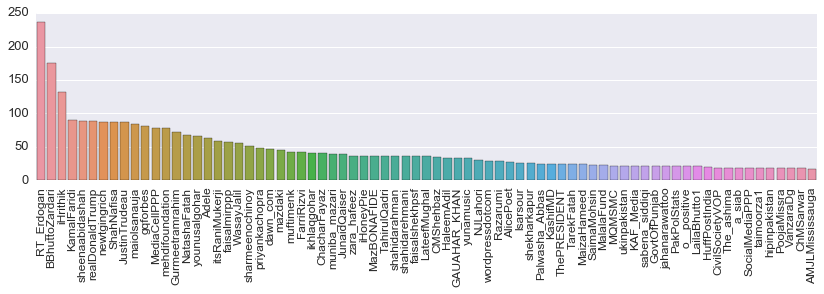

In [26]:
x, y = zip(*counter_mentions.most_common(75))
f, ax = plt.subplots(figsize=(14, 3))
sns.barplot(x=x, y=y)
plt.yticks(fontsize=13)
plt.xticks(rotation=90, fontsize=12)

In [27]:
counter_media = Counter()
for tweet in recent_tweets:
    counter_media.update([m['media_url_https'] for m in tweet['entities'].get('media', [])])

In [28]:
counter_media.most_common(25)

[('https://pbs.twimg.com/media/CelRU-pW4AEIM4c.jpg', 84),
 ('https://pbs.twimg.com/media/Ceqpg57XEAEruVX.jpg', 81),
 ('https://pbs.twimg.com/media/Cet83NdWAAA9Q94.jpg', 58),
 ('https://pbs.twimg.com/media/Ce9aGztWAAAw-yn.jpg', 36),
 ('https://pbs.twimg.com/media/Ce0KFxSWEAAyLEB.jpg', 34),
 ('https://pbs.twimg.com/media/Ce4T-J8XEAATXs1.jpg', 34),
 ('https://pbs.twimg.com/media/Ce3JDghWEAAi1nU.jpg', 33),
 ('https://pbs.twimg.com/media/CeuHGHSWIAAorhX.jpg', 30),
 ('https://pbs.twimg.com/media/Cey6iRIW8AAH1Eq.jpg', 29),
 ('https://pbs.twimg.com/media/CfAx1uZXEAQMJha.jpg', 23),
 ('https://pbs.twimg.com/media/CekXiwQWAAAwcpO.jpg', 23),
 ('https://pbs.twimg.com/ext_tw_video_thumb/714146534300975104/pu/img/qoMuV4LSwHhLqpKi.jpg',
  22),
 ('https://pbs.twimg.com/media/CezVk1fVAAAUdEU.jpg', 21),
 ('https://pbs.twimg.com/media/CewsuVgXEAAS9ns.jpg', 21),
 ('https://pbs.twimg.com/media/Ce27VqbWEAAIUvI.jpg', 20),
 ('https://pbs.twimg.com/ext_tw_video_thumb/715465534138089472/pu/img/Kw2gRbtGbYqhdScX.j

In [29]:
images = [Image(url) for url, count in counter_media.most_common(10)]

84 references to https://pbs.twimg.com/media/CelRU-pW4AEIM4c.jpg


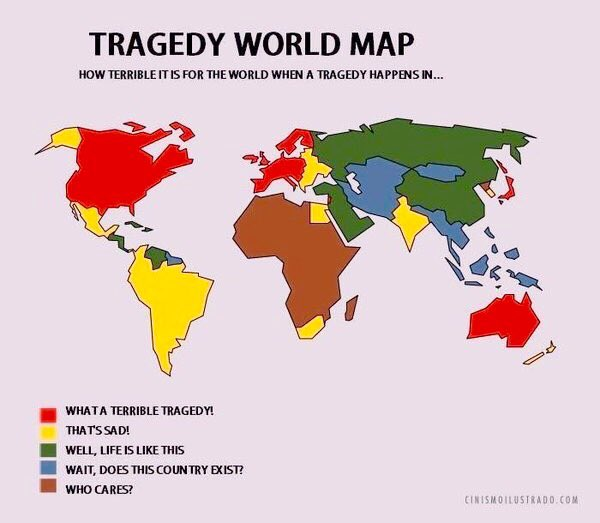

81 references to https://pbs.twimg.com/media/Ceqpg57XEAEruVX.jpg


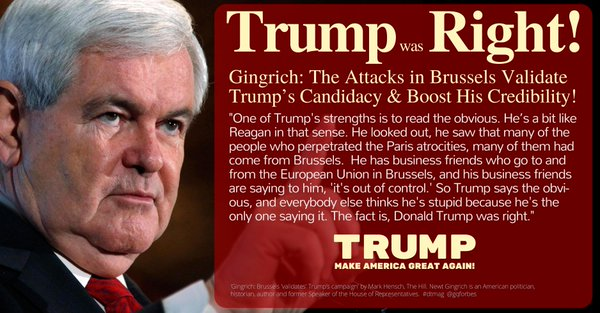

58 references to https://pbs.twimg.com/media/Cet83NdWAAA9Q94.jpg


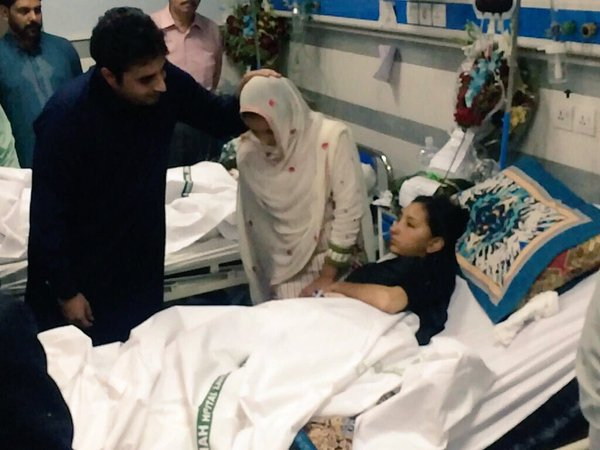

36 references to https://pbs.twimg.com/media/Ce9aGztWAAAw-yn.jpg


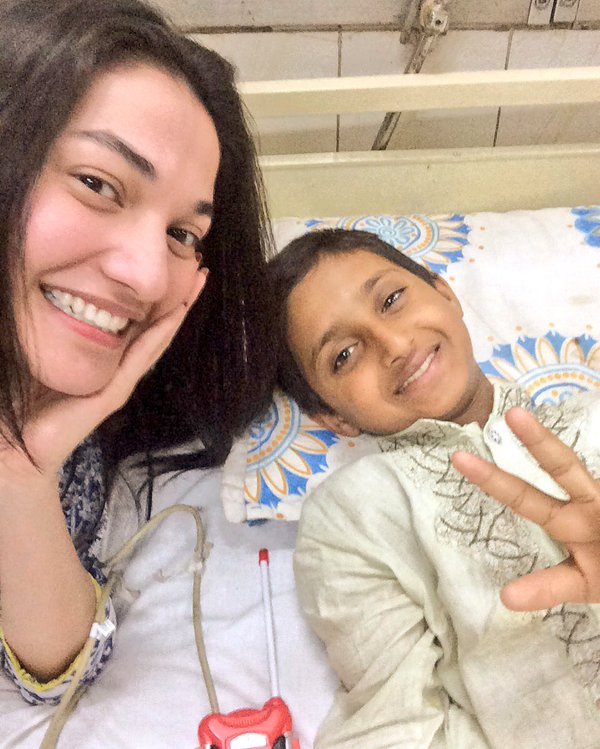

34 references to https://pbs.twimg.com/media/Ce0KFxSWEAAyLEB.jpg


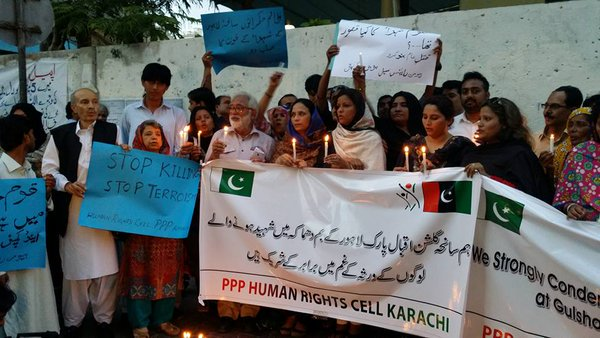

34 references to https://pbs.twimg.com/media/Ce4T-J8XEAATXs1.jpg


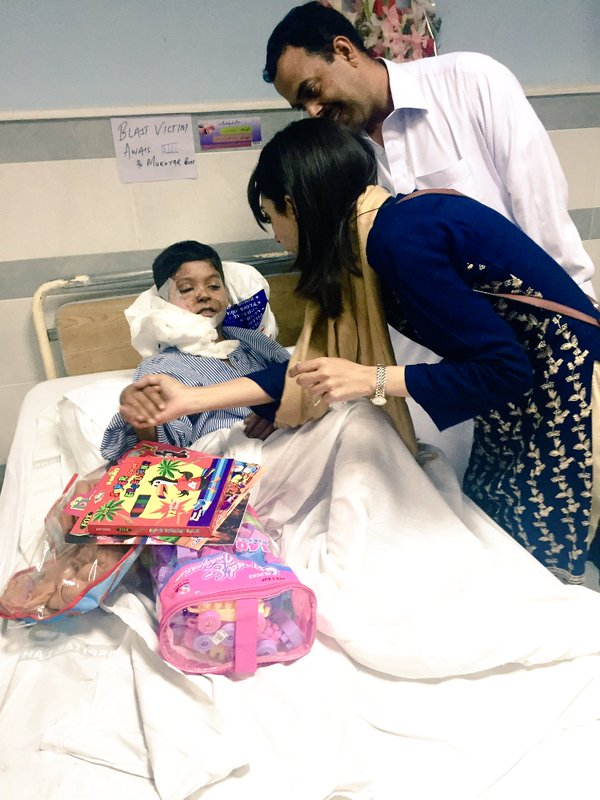

33 references to https://pbs.twimg.com/media/Ce3JDghWEAAi1nU.jpg


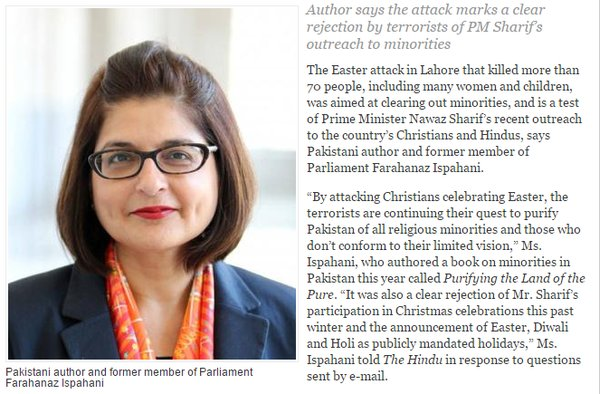

30 references to https://pbs.twimg.com/media/CeuHGHSWIAAorhX.jpg


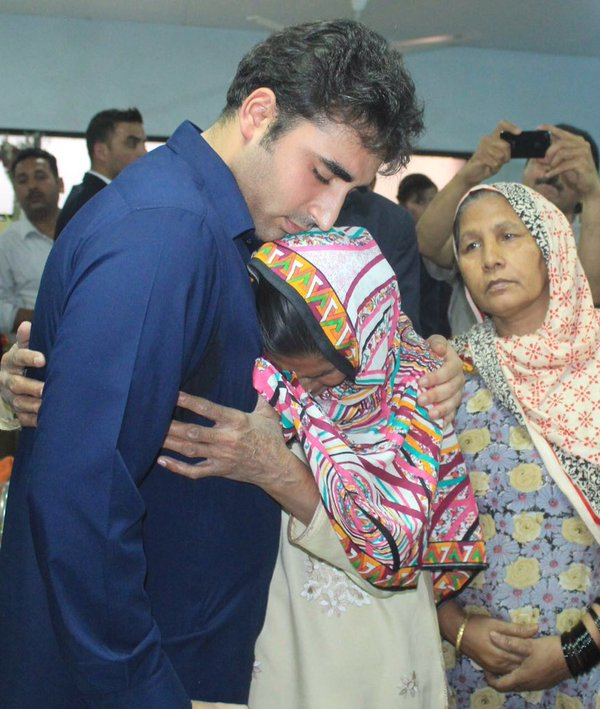

29 references to https://pbs.twimg.com/media/Cey6iRIW8AAH1Eq.jpg


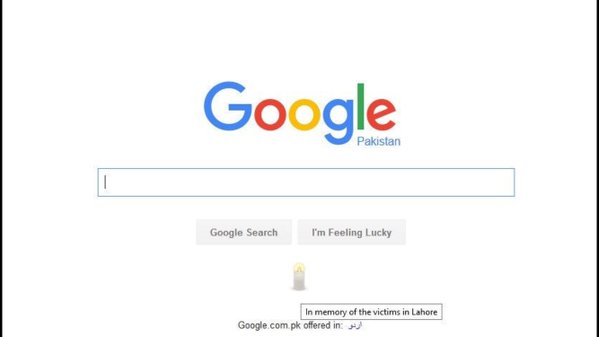

23 references to https://pbs.twimg.com/media/CfAx1uZXEAQMJha.jpg


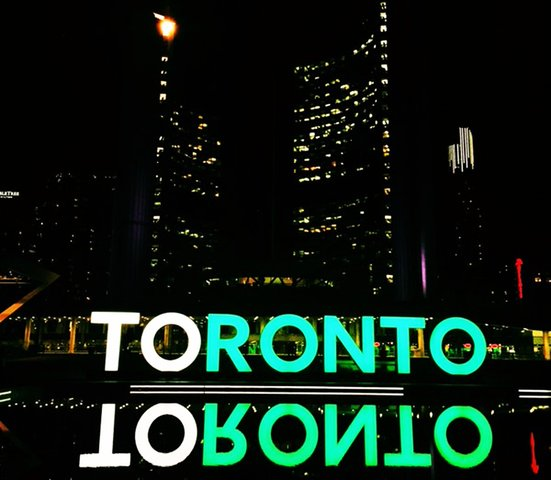

In [31]:
for url, count in counter_media.most_common(10):
    print('%s references to %s' % (count, url))
    display(Image(url))

## Popular tweets and popular mentions

Let's go another level deeper and examine the most popular tweets and the most-mentioned users.  We already have them both in hand:

In [32]:
popular = get_tweets(25, result_type='popular')

In [33]:
[t['text'] for t in popular]

['The world seems to be infested with heartless sick people..heartbreaking news.My prayers to the families of the victims #LahoreBlast',
 "I don't care what your fighting for but u do this to children u are going to burn in hell. #LahoreBlast",
 "Malala's statement on the tragic #LahoreBlast today. https://t.co/2xrSoGK6Yq",
 'Canada condemns the deplorable bombing in Lahore, Pakistan. Our thoughts and prayers are with all those killed or injured. #LahoreBlast',
 "It's a park for gods sake!! Children on swings!! How can anybody even have the heart to do this. #LahoreBlast",
 'What kind of evil would kill innocent women and children.. this is just pure evil! #PrayForPakistan #LahoreBlast',
 'I strongly condemn the terrorist attack that took place in Lahore yesterday. Turkey stands by Pakistan as it always has been. #LahoreBlast',
 'Must watch report by @SaimaMohsin on the #LahoreBlast https://t.co/pb1HmsNfxI',
 'no,\nJannat is not for u\nfor ur soul \nwill forever be trapped\nin death cr

In [186]:
for t in popular:
    u = t['user']
    print('Screen name "%s", name "%s"' % (u['screen_name'], u['name']))

Screen name "priyankachopra", name "PRIYANKA"
Screen name "MalalaFund", name "Malala Fund"
Screen name "JustinTrudeau", name "Justin Trudeau"
Screen name "iHrithik", name "Hrithik Roshan"
Screen name "TheMahiraKhan", name "Mahira Khan"
Screen name "yunamusic", name "Yuna Zarai"
Screen name "karanjohar", name "Karan Johar"
Screen name "realpreityzinta", name "Preity zinta"
Screen name "Riteishd", name "Riteish Deshmukh"
Screen name "shekharkapur", name "Shekhar Kapur"
Screen name "ayushmannk", name "Ayushmann Khurrana"
Screen name "irrfan_k", name "irrfan"
Screen name "BBCBreaking", name "BBC Breaking News"
Screen name "RT_Erdogan", name "Recep Tayyip Erdoğan"
Screen name "M_IrfanOfficial", name "Mohammad Irfan"
Screen name "SAMAATV", name "SAMAA TV"


In [34]:
popular_screen_names = set([t['user']['screen_name'] for t in popular])
screen_names, counts = zip(*counter_mentions.most_common(1000))
common_mentions = set(screen_names)

All of the following screen names are both *authors* of popular tweets and *mentions* of many other users.

In [35]:
popular_screen_names.intersection(common_mentions)

{'JustinTrudeau',
 'MalalaFund',
 'RT_Erdogan',
 'Riteishd',
 'TheMahiraKhan',
 'ayushmannk',
 'iHrithik',
 'karanjohar',
 'priyankachopra',
 'sharmeenochinoy',
 'shekharkapur',
 'yunamusic',
 'zeyadkhan'}

But these remaining few are authors of popular tweets but not as commonly mentioned.

In [36]:
popular_screen_names.difference(common_mentions)

{'realpreityzinta'}

Let's take a closer look at the follow/follower counts of these two sets of users.  We should be able to pull the key data out from the tweets we already have.

In [37]:
for t in popular:
    u = t['user']
    print('%s (%s): %s followers, following %s' % (u['screen_name'], u['name'],
                                                   u['followers_count'], u['friends_count']))

priyankachopra (PRIYANKA): 13446311 followers, following 480
iHrithik (Hrithik Roshan): 13487280 followers, following 114
MalalaFund (Malala Fund): 429379 followers, following 452
JustinTrudeau (Justin Trudeau): 1549306 followers, following 925
TheMahiraKhan (Mahira Khan): 143567 followers, following 72
yunamusic (Yuna Zarai): 1476358 followers, following 1015
RT_Erdogan (Recep Tayyip Erdoğan): 8156131 followers, following 2
sharmeenochinoy (Sharmeen Obaid): 125159 followers, following 1090
shekharkapur (Shekhar Kapur): 1558003 followers, following 371
karanjohar (Karan Johar): 8396253 followers, following 387
realpreityzinta (Preity zinta): 4041335 followers, following 73
Riteishd (Riteish Deshmukh): 4897200 followers, following 248
shekharkapur (Shekhar Kapur): 1558003 followers, following 371
ayushmannk (Ayushmann Khurrana): 2739805 followers, following 301
zeyadkhan (Zeyad Masroor Khan): 1309 followers, following 999
priyankachopra (PRIYANKA): 13446311 followers, following 480
iHri

Tweepy has [handy methods for collecting friend/follower](http://tweepy.readthedocs.org/en/v3.5.0/api.html#API.friends_ids) info for given users.  Let's pull that in and construct a network of who these popular twitterers are following.

In [38]:
import tweepy
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth)

In [ ]:
follow_net = []
user_set = set()
for user in [t['user'] for t in popular]:
    print('Fetching users for %s' % user['screen_name'])
    time.sleep(120)
    user_id = user['id']
    follows = api.friends_ids(user_id)
    follow_net.append((user_id, follows))
    user_set.update(follows)

Fetching users for priyankachopra


Unfortunately the rate limiting on that function call is severe: 15 calls every 15 minutes.  When debugging, you run into that quickly!

Oh well, we got enough data to move forward some.  First, let's see how much overlap there might be by checking the overall set against the complete count of each following list.

In [ ]:
[x for x, y in follow_net]

In [325]:
len(user_set)

4080

In [326]:
sum([len(ids) for u, ids in follow_net])

4780

That's already a significant difference.  The graph should show this clearly.

In [371]:
g = nx.Graph()
for user_id, friends_ids in follow_net:
    for friend_id in friends_ids:
        g.add_edge(str(user_id), str(friend_id))

In [381]:
sg = nx.Graph()
popular_ids = [t['user']['id'] for t in popular]
for node in sorted(g.nodes()):
    if node in [str(i) for i in popular_ids]:
        continue
    if len(g.edges(node)) > 3:
       sg.add_edges_from(g.edges(node))

In [382]:
labels = {}
follow_net_users = [x for x, y in follow_net]
for u in [t['user'] for t in popular]:
    if u['id'] in follow_net_users:
        labels[str(u['id'])] = u['screen_name']

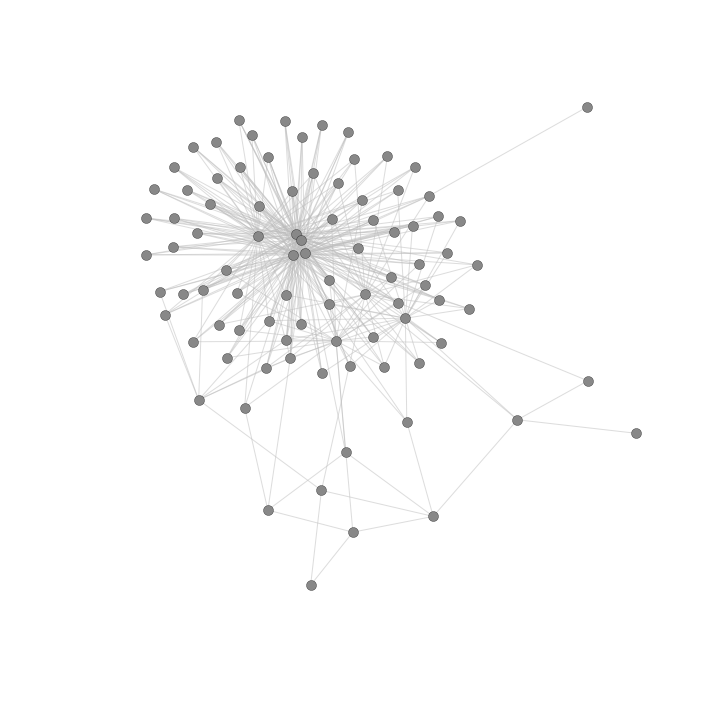

In [386]:
plt.figure(figsize=(12, 12))
pos = nx.fruchterman_reingold_layout(sg)
nx.draw_networkx_nodes(sg, pos, node_size=100, node_color='#888888')
nx.draw_networkx_edges(sg, pos, edge_color='#bbbbbb',
                 arrows=False, alpha=0.5)
#nx.draw_networkx_labels(sg, pos, labels, fontsize=18)
plt.axis('off')
plt.show()